In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('seaborn-whitegrid')

font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)


# Aux functions

def plot_grid(Xs, Ys, axs=None):
    ''' Aux function to plot a grid'''
    t = np.arange(Xs.size) # define progression of int for indexing colormap
    if axs:
        axs.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        axs.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        axs.axis('scaled') # axis scaled
    else:
        plt.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        plt.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        plt.axis('scaled') # axis scaled
        
def linear_map(A, Xs, Ys):
    '''Map src points with A'''
    # [NxN,NxN] -> NxNx2 # add 3-rd axis, like adding another layer
    src = np.stack((Xs,Ys), axis=Xs.ndim)
    # flatten first two dimension
    # (NN)x2
    src_r = src.reshape(-1,src.shape[-1]) #ask reshape to keep last dimension and adjust the rest
    # 2x2 @ 2x(NN)
    dst = A @ src_r.T # 2xNN
    #(NN)x2 and then reshape as NxNx2
    dst = (dst.T).reshape(src.shape)
    # Access X and Y
    return dst[...,0], dst[...,1]


def plot_points(ax, Xs, Ys, col='red', unit=None, linestyle='solid'):
    '''Plots points'''
    ax.set_aspect('equal')
    ax.grid(True, which='both')
    ax.axhline(y=0, color='gray', linestyle="--")
    ax.axvline(x=0, color='gray',  linestyle="--")
    ax.plot(Xs, Ys, color=col)
    if unit is None:
        plotVectors(ax, [[0,1],[1,0]], ['gray']*2, alpha=1, linestyle=linestyle)
    else:
        plotVectors(ax, unit, [col]*2, alpha=1, linestyle=linestyle)

def plotVectors(ax, vecs, cols, alpha=1, linestyle='solid'):
    '''Plot set of vectors.'''
    for i in range(len(vecs)):
        x = np.concatenate([[0,0], vecs[i]])
        ax.quiver([x[0]],
                   [x[1]],
                   [x[2]],
                   [x[3]],
                   angles='xy', scale_units='xy', scale=1, color=cols[i],
                   alpha=alpha, linestyle=linestyle, linewidth=2)

# RECAP OF THE PREVIOUS LECTURE
- Principal Components Analysis (PCA).
- Eigendecomposition of a matrix.
- Geometry behind PCA.
- Application of PCA for:
    - Compressing the data (point cloud to line);
    - Modeling 3D Faces (3D Morphable Model  3DMM);
    - Rotating the data.

## TODAY'S LECTURE
### Unsupervised learning: clustering
### K-means
### Coordinate descent
### Application: pixel segmentation
### Image recognition: visual bag of words (hints)

# THIS LECTURE MATERIAL IS TAKEN FROM:
- [Cimi Book - Chapter 15](http://ciml.info/dl/v0_99/ciml-v0_99-ch15.pdf)
- [Bishop - Chapter 9.1](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)
- [Stanford Kmeans](https://www.youtube.com/watch?v=LmpkKwsyQj4)
- [Stanford Kmeans](http://cs229.stanford.edu/syllabus-summer2020.html)
- [Illustrations](https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch11/ch11.ipynb)
- [Code](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)

# UNSUPERVISED LEARNING

**Objective and Motivation:** the goal of unsupervised learning is to find **hidden patterns** in unlabeled data. 

\begin{equation}
 \underbrace{\{\mathbf{x}_i\}_{i=1}^N}_{\text{known}} \sim \underbrace{\mathcal{D}}_{\text{unknown}}
\end{equation}


- Unlike in supervised learning, the data points are not paired with a label.

- As you can see the unsupervised learning problem is ill-posed (which hidden patterns ?) and in principle more difficult than supervised learning.

- Unsupervised learning can be thought of as "finding structure" in the data.

# UNSUPERVISED LEARNING


QUESTION: are PCA (principal components analysis), Eigendecomposition and SVD (singular value decomposition) used in **unsupervised learning** ?

Yes, all of these methods, i.e., principal component analysis (PCA), eigendecomposition, and singular value decomposition (SVD), are commonly used in unsupervised learning.

PCA is a technique used to reduce the dimensionality of a dataset by transforming it into a new coordinate system in which the principal components are orthogonal to each other and capture the maximum variance in the original dataset.

Eigendecomposition is a mathematical technique used to decompose a matrix into its eigenvectors and eigenvalues. In unsupervised learning, it is often used to compute the principal components of a dataset, which can then be used for dimensionality reduction and other purposes.

Singular value decomposition (SVD) is a similar matrix factorization technique that can be used to decompose a matrix into its singular values, left singular vectors, and right singular vectors. SVD is particularly useful for matrix approximation and data compression, as well as for dimensionality reduction and other unsupervised learning tasks.

All of these techniques are used extensively in unsupervised learning and are valuable tools for exploring and analyzing high-dimensional datasets.

- "Hidden patterns" and "finding structure" translate into find a **low dimensional embedding** of the data.
- Usage:
    - Visualization of high dimensional data;
    - Dimensionality reduction;
    - Compression and noise filtering;
    - Further pre-processing by Machine Learning algorithms;
    - Decorrelate the features  (i.e. *the covariance matrix becomes a diagonal matrix*).

# UNSUPERVISED LEARNING: CLUSTERING

- "Hidden patterns" and "finding structure" translate into **deriving a partitioning of the data into clusters**.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# Generate sample data
X, y = make_blobs(n_samples=150,
                  n_features=2,
                  centers=3,
                  cluster_std=0.3,
                  shuffle=True,
                  random_state=0)

# Visualize the data
plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolor='black', s=50)
plt.grid()
plt.show()

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_kmeans = kmeans.fit_predict(X)

# Visualize the clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s=50, c='red', label='Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s=50, c='blue', label='Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s=50, c='green', label='Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, marker='*', c='black', label='Centroids')
plt.legend()
plt.grid()
plt.show()

## SUPERVISED LEARNING IS MORE CONSTRAINED

- The mapping data to color (labels) is given.
- With clustering, we are given just a point cloud of data with no label assigned. 🤯

# CLUSTERING IS ILL-POSED

In [ ]:
from sklearn.datasets import make_blobs

X2, y2 = make_blobs(n_samples=150, 
                  n_features=2, 
                  centers=3, 
                  cluster_std=.7, 
                  shuffle=True, 
                  random_state=0)

plt.scatter(X2[:, 0], X2[:, 1], c='black', marker='o', s=50)
plt.show()

- How many cluster do we have here, three or two ? 😕🙃

# WHY CLUSTERING IS USEFUL ?

- Applications: 
    - Color compression;
    - Vector "quantization";
    - Data compression;
    - Image Retrieval (codebook) --> Bag of visual words;
    - Finding "groups" given points in a vector space: 
        - I.e. Marketing department: you have a customer as a vector.
            - Each axis of the vector indicates 1) annual income 2) Age 3) Location etc.
            - Objective: identify "groups" of customers to have ad-hoc advertising campaign.

# CLUSTERING: FORMALIZING THE PROBLEM

- **Input**:
    1. $\quad$ A set of points $\{ {x}_1, \ldots, {x_n}\}$ in a d-dim vector space ${x} \in \mathbb{R}^d$;
    2. $\quad$ $k$ number of clusters to find.

- **Output**:
    1. $\quad$ A set of points **"centroids"** $\{ {\mu}_1, \ldots, {\mu}_k\}$ where ${\mu} \in \mathbb{R}^d$;
    2. $\quad$ A set of **assignment labels** that create a **mapping from data points to centroids** $\{ y_1, \ldots, y_n\}$;
    3. The clusters are meant to be disjoint (there is no overlap between clusters).
     - Note that $y$ is a scalar $\in [1,\ldots,k]$.
     - The assignment labels maps a data point to a single centroid.
     - It conveys the information: `data points 3 maps to the cluster centroid 2`.
     - For this to work formally the $y_i$ needs to be aligned with ${x}_i$.

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c='black', marker='o', s=50)
plt.show()

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50,
            c='lightgreen',
            marker='s',
            label='cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,
            c='orange',
            marker='o',
            label='cluster 2')
plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50,
            c='lightblue',
            marker='v',
            label='cluster 3')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250,
            marker='*',
            c='red',
            label='centroids')
plt.legend()
plt.tight_layout()
plt.show()

# CLUSTERING: K-MEANS ALGORITHM

- Solving this problem in an **optimal** way is an **NP-Hard** problem.
- A **non-optimal solution** to this problem can be obtained with **K-means algorithm.**
- In practice, K-means plus other heuristics make the approach usable in multiple problems.

Remember that we have to find:

1. $\quad$ A set of points **"centroids"** $\{ {\mu}_1, \ldots, {\mu}_k\}$ where ${\mu} \in \mathbb{R}^d$; 
2. $\quad$ A set of **assignment labels** that create a **mapping from data points to centroids** $\{ y_1, \ldots, y_n\}$ .

# LET'S THINK HOW WE CAN SOLVE IT

## WHAT WOULD YOU DO ?

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c='black', marker='o', s=50)
plt.show()

#### 1. We need some "reference" centroids to start
 - **Initialization:** `RANDOM` sample the $K$ centroids $\{ {\mu}_1, \ldots, {\mu}_k\}$.
 
 - A trick is using available points (just choose a few of them).
 
 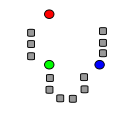

#### 2. Assignment step
- For every point $i=[1,\ldots,N]$ compute the assignment w.r.t. to the $K$ clusters.
    - We have to compare $N\times K$ points (`#data points x #clusters`).
    - Given a point ${x}_i$, **we have to find the label of the "closest" centroids in $\{ {\mu}_1, \ldots, {\mu}_k\}$**
        -  $y_i =  \arg\min_k || {x}_i -{\mu}_k ||_2^2 $.
    
    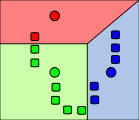
    
- At the end of this step we should have a pair of aligned set $\{ {x}_1, \ldots, {x_n}\}$ and $\{ {y}_1, \ldots, {y_n}\}$.

#### 3. Update Step

- Now, it is the **inverse** of before. Now we consider the "centroids".
- For every centroid $k=[1,\ldots,K]$ **we update its mean based on the previous assignments:**
- Given a ${\mu}_k$, we update it as  ${\mu}_k \leftarrow \frac{\sum_i \delta\{y_i=k\}{x}_i}{\sum_i \delta\{y_i=k\}}$
    
    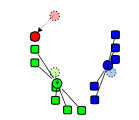
    
    
- At the end of this step we should have a pair of aligned set $\{ {x}_1, \ldots, {x_n}\}$ and $\{ {y}_1, \ldots, {y_n}\}$ and **updated centroids** $\{ {\mu}_1, \ldots, {\mu}_k\}$.

### Indicator function

$$
\delta_{ij} = \begin{cases}
0 &\text{if } i \neq j,   \\
1 &\text{if } i=j.   \end{cases}
$$

It is a formalism to express the concept of:
- DO consider the point in the mean computation if point label corresponds to current centroid.
- DO NOT consider the point in the mean computation if point label DOES NOT corresponds to current centroid.

Final result

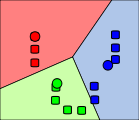

<img width="40%" src='https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif' />

# K-MEANS (Lloyd’s method)

1. **Random init of centroids**
2. Repeat until convergence:
    - **Assignment step:** $\forall i\in[1,N] \quad y_i =  \arg\min_k || {x}_i -{\mu}_k ||_2^2 $
    - **Update step:** $\forall k\in[1,K] \quad  {\mu}_k \leftarrow \frac{\sum_i \delta\{y_i=k\}{x}_i}{\sum_i \delta\{y_i=k\}}$
   
What does "convergence" mean?

## K-MEANS CONVERGENCE
- One could check that the centroids do not change anymore (up to some $\epsilon$), even performing more steps.
- Is there a better "convergence" term ? We will look into this later.

# LET'S IMPLEMENT A BASIC VERSION WITH NUMPY AND MATPLOTLIB

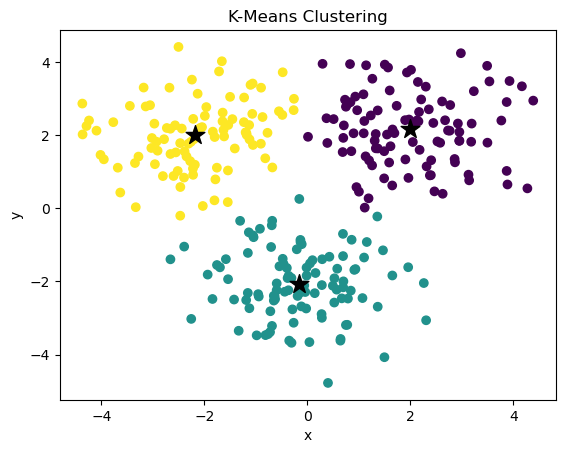

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def kmeans(X, K, max_iters=100):
    """K-Means clustering algorithm using Lloyd's method.
    
    Parameters:
    X (ndarray): Input data of shape (N, D), where N is the number of data points
        and D is the number of dimensions.
    K (int): Number of clusters.
    max_iters (int): Maximum number of iterations to run the algorithm.
    
    Returns:
    ndarray: Final cluster centers of shape (K, D).
    ndarray: Indices of the closest cluster for each data point of shape (N,).
    """
    # Initialize cluster centers randomly
    idx = np.random.choice(X.shape[0], K, replace=False)
    centers = X[idx, :]
    
    # Run K-Means algorithm
    for i in range(max_iters):
        # Assign each data point to the closest cluster center
        distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
        closest_cluster = np.argmin(distances, axis=1)
        
        # Update cluster centers based on the mean of the assigned data points
        for j in range(K):
            cluster_points = X[closest_cluster == j, :]
            if len(cluster_points) > 0:
                centers[j, :] = np.mean(cluster_points, axis=0)
        
    return centers, closest_cluster
    
# Generate sample data
np.random.seed(0)
X = np.vstack([
    np.random.randn(100, 2) + [2, 2],
    np.random.randn(100, 2) + [0, -2],
    np.random.randn(100, 2) + [-2, 2],
])

# Run K-Means clustering
K = 3
centers, closest_cluster = kmeans(X, K)

# Plot the results
plt.scatter(X[:, 0], X[:, 1], c=closest_cluster, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], s=200, marker='*', c='black')
plt.title('K-Means Clustering')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# LET'S TRY A LARGER DATASET

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=5000, 
                  n_features=3, 
                  centers=25, 
                  cluster_std=1.25, 
                  shuffle=True, 
                  random_state=0)

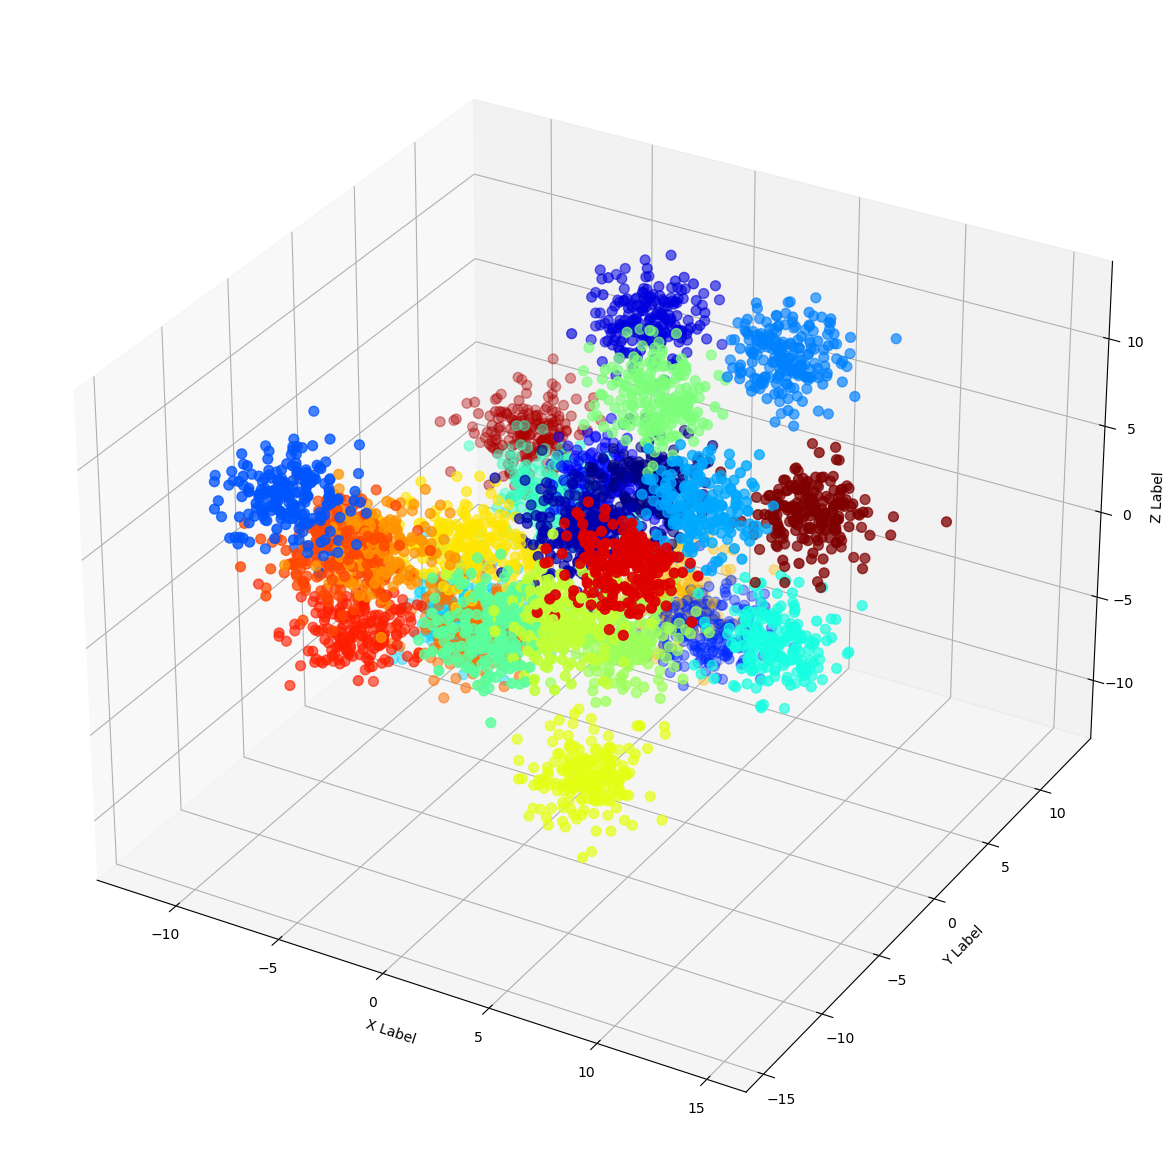

In [3]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')

ax.scatter(*X.T, c=y,
            s=50, cmap='jet')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
_ = ax.set_zlabel('Z Label')

In [4]:
centers, y_est = kmeans(X, 20)

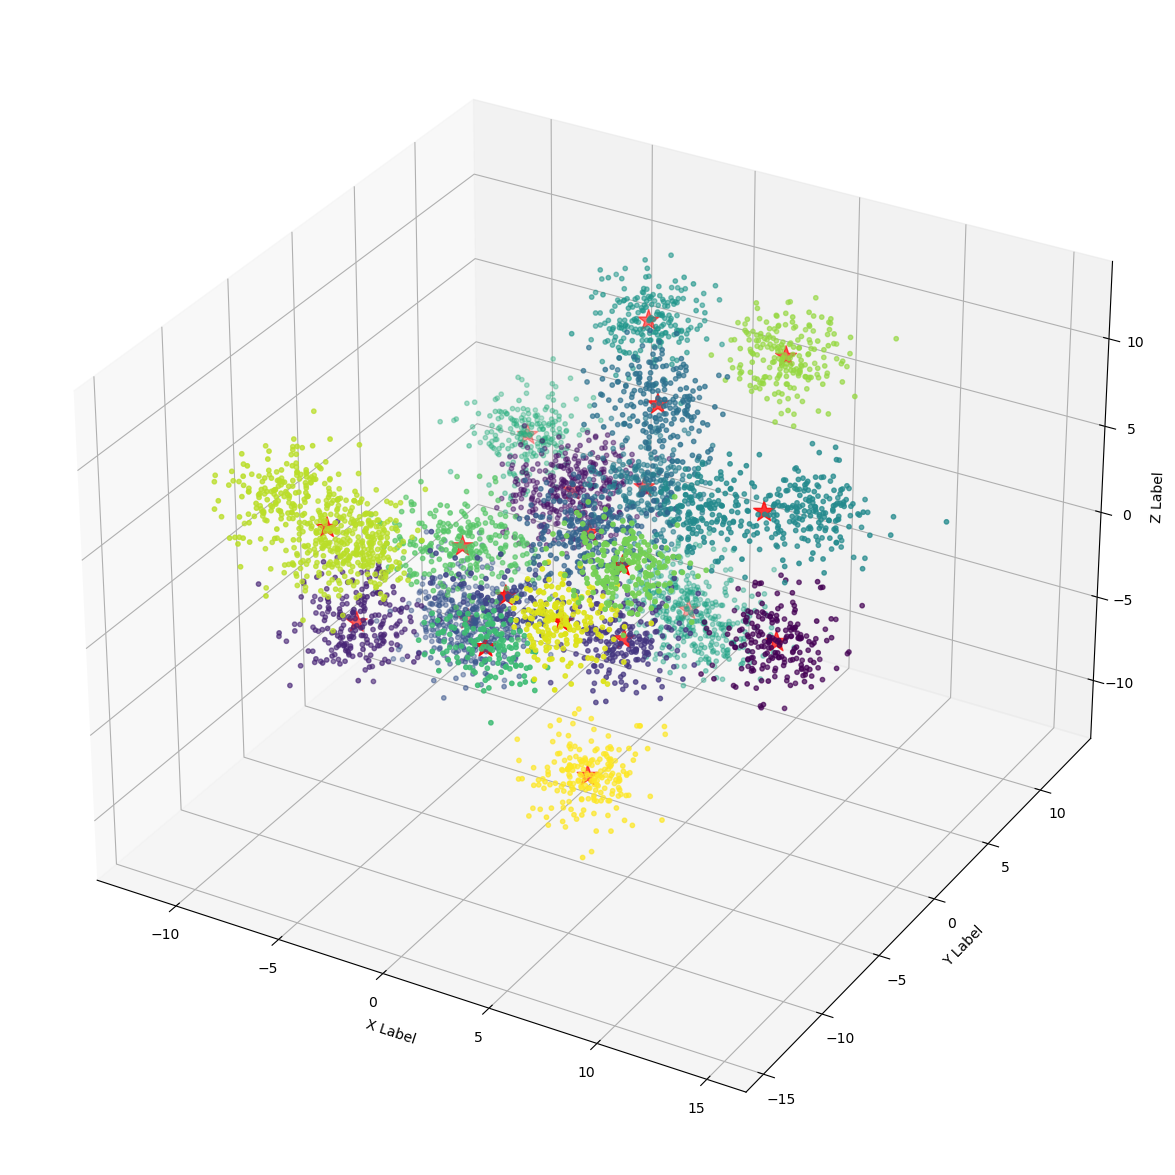

In [5]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')

ax.scatter(*X.T, c=y_est,
            s=10, cmap='viridis')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
_ = ax.set_zlabel('Z Label')
_ = ax.scatter(*centers.T,
                s=250,
                marker='*',
                c='red',
                label='centroids')

# VISUALIZATION

[Taken from this website](https://jakevdp.github.io/PythonDataScienceHandbook/06.00-figure-code.html#Expectation-Maximization)

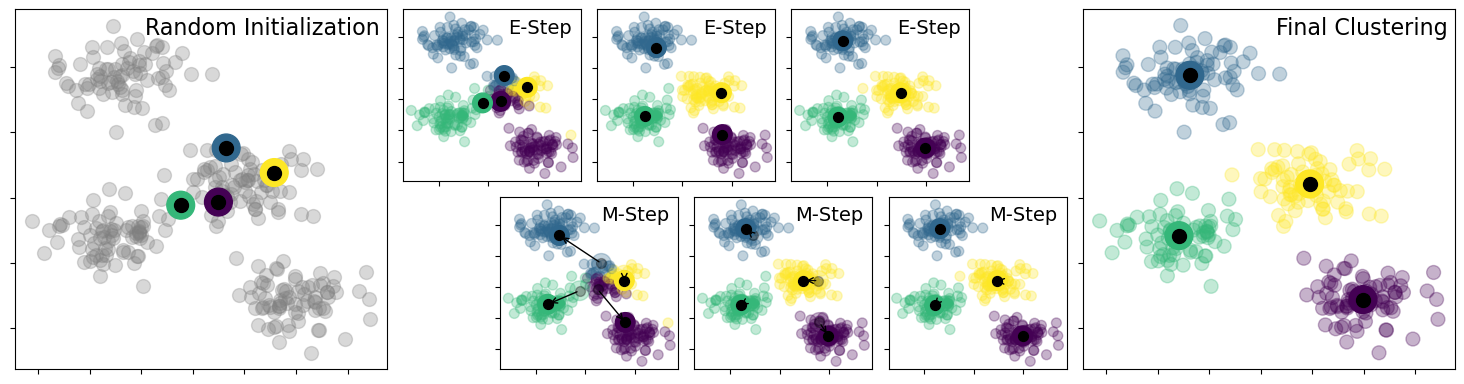

In [6]:
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances_argmin

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

rng = np.random.RandomState(42)
centers = [0, 4] + rng.randn(4, 2)

def draw_points(ax, c, factor=1):
    ax.scatter(X[:, 0], X[:, 1], c=c, cmap='viridis',
               s=50 * factor, alpha=0.3)
    
def draw_centers(ax, centers, factor=1, alpha=1.0):
    ax.scatter(centers[:, 0], centers[:, 1],
               c=np.arange(4), cmap='viridis', s=200 * factor,
               alpha=alpha)
    ax.scatter(centers[:, 0], centers[:, 1],
               c='black', s=50 * factor, alpha=alpha)

def make_ax(fig, gs):
    ax = fig.add_subplot(gs)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    return ax

fig = plt.figure(figsize=(15, 4))
gs = plt.GridSpec(4, 15, left=0.02, right=0.98, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)
ax0 = make_ax(fig, gs[:4, :4])
ax0.text(0.98, 0.98, "Random Initialization", transform=ax0.transAxes,
         ha='right', va='top', size=16)
draw_points(ax0, 'gray', factor=2)
draw_centers(ax0, centers, factor=2)

for i in range(3):
    ax1 = make_ax(fig, gs[:2, 4 + 2 * i:6 + 2 * i])
    ax2 = make_ax(fig, gs[2:, 5 + 2 * i:7 + 2 * i])
    
    # E-step
    y_pred = pairwise_distances_argmin(X, centers)
    draw_points(ax1, y_pred)
    draw_centers(ax1, centers)
    
    # M-step
    new_centers = np.array([X[y_pred == i].mean(0) for i in range(4)])
    draw_points(ax2, y_pred)
    draw_centers(ax2, centers, alpha=0.3)
    draw_centers(ax2, new_centers)
    for i in range(4):
        ax2.annotate('', new_centers[i], centers[i],
                     arrowprops=dict(arrowstyle='->', linewidth=1))
        
    
    # Finish iteration
    centers = new_centers
    ax1.text(0.95, 0.95, "E-Step", transform=ax1.transAxes, ha='right', va='top', size=14)
    ax2.text(0.95, 0.95, "M-Step", transform=ax2.transAxes, ha='right', va='top', size=14)


# Final E-step    
y_pred = pairwise_distances_argmin(X, centers)
axf = make_ax(fig, gs[:4, -4:])
draw_points(axf, y_pred, factor=2)
draw_centers(axf, centers, factor=2)
axf.text(0.98, 0.98, "Final Clustering", transform=axf.transAxes,
         ha='right', va='top', size=16)


fig.savefig('figs/05.11-expectation-maximization.png')

# ASSUMPTIONS & LIMITATIONS OF K-MEANS

- This example is meant to illustrate situations where k-means will produce unintuitive and possibly unexpected clusters. In the first three plots, the input data does not conform to some implicit assumption that k-means makes and undesirable clusters are produced as a result. 
- In the last plot, k-means returns intuitive clusters despite unevenly sized blobs.

<img width='40%' src="https://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_assumptions_001.png" />

# ILL-POSED DATA POINTS

In [ ]:
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans

X, y = make_moons(200, noise=.05, random_state=0)
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

# CLUSTERS BOUNDED BY LINEAR BOUNDARIES

# INTERPRETATION OF CLUSTER BOUNDARIES AS "VORONOI" DIAGRAM

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_digits_001.png" />

# WHAT IS A VORONOI REGION ?

A Voronoi region, also known as a Voronoi cell or Voronoi polygon, is a geometric concept that is used to partition space into regions based on the proximity of points in a set.

Given a set of points in a space, the Voronoi region for a particular point is defined as the region of space that is closer to that point than to any other point in the set. The boundary of the Voronoi region is formed by the points that are equidistant to the two closest points in the set.

The collection of all Voronoi regions for a given set of points is called a Voronoi diagram, and it provides a way to visualize the partitioning of space based on proximity to the points in the set. Voronoi diagrams have a wide range of applications in various fields such as computer graphics, geography, and physics.

Given a set of points $P_k$ and a distance metric $d(x,y) = \ell_2(x-y)$ and $d(x,\, A) = \inf\{d(x,\, a) \mid a \in A\}$

 $$ R_k = \{x \in X \mid d(x, P_k) \leq d(x, P_j)\; \text{for all}\; j \neq k\} $$
 
- Points in a regions could be thought as belonging to that cluster.
- Points between two regions (along a segment) are boundary points between two classes.
- A point between three regions (along a single point) is boundary points between two classes.

<img width='40%' src="https://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_digits_001.png" />

# "THEORY" BEHIND K-MEANS

- Are we guaranteed that K-means will always converge ? Could we get stuck in an infinite loop ?
- Are we reching a global optimum in the solution ?
- How much does the "initialization" step matter ?

# K-MEANS AS A LOSS MINIMIZATION PROBLEM

Similarly as for PCA, we can define a **loss or cost function** that can better formalize the K-means algorithm.

$$ \mathcal{L}({\mu},y;{D}) = \sum_{i=1}^N \left| \left| {x}_i - {\mu}_{y_i} \right|\right|_2^2 $$

- Criterion for separating samples in $K$ groups of equal variance, minimizing a the "inertia" or "within-cluster sum-of-squares" (within cluster variance).
- Sum of squared distances from any data point to its assigned center.

$$ \mathcal{L}({\mu},y;{D}) = \sum_{i=1}^N \left| \left| {x}_i - {\mu}_{y_i} \right|\right|_2^2 =
\sum_{i=1}^N \min_{k \in K} \Big(\left| \left|  {x}_i - {\mu}_{k} \right|\right|_2^2 \Big)
$$

# CONVERGENCE
- Are we guaranteed that K-means will always converge ? Could we get stuck in an infinite loop ?

> Yes, we are guaranteed that K-means will always converge yet to a **LOCAL** optimum.

For any dataset **D** and any number of clusters *K*, the K-means algorithm converges in a **finite number of iterations**, where convergence is measured by the loss ceasing the change.

There are only two points in which the K-means algorithm changes its values:
- **Assignment step:** $\forall i\in[1,N] \quad y_i =  \arg\min_k || {x}_i -{\mu}_k ||_2^2 $
- **Update step:** $\forall k\in[1,K] \quad  {\mu}_k \leftarrow \frac{\sum_i \delta\{y_i=k\}{x}_i}{\sum_i \delta\{y_i=k\}}$
    
We will show that both of these operations can never increase the value of  $\mathcal{L}$. 
Assuming this is true, the rest of the argument is as follows:
- The possible assignments to $y$ and ${\mu}$ can only take a finite number of values.
    - because $y$ is a discrete value.
    - ${\mu}$ is all possible means of a subset of data (it is not infinite).
    - The loss $\mathcal{L}$ is lower bounded by zero by $\ell_2$ property.
- Together means that $\mathcal{L}$ cannot decrease more than a  finite number of times.

It remains to show that the two steps can only decrease the loss.
1. **Assignment step:** $\forall i\in[1,N] \quad y_i =  \arg\min_k || {x}_i -{\mu}_k ||_2^2 $

Looking at a point $i$ suppose that the previous value of $y_i$ is $a$ and the new value is $b$. 
It must be the case that  $|| {x}_i -{\mu}_b ||_2^2 \leq || {x}_i -{\mu}_a ||_2^2 $.
Thus, changing from $a \mapsto b$ **can only decrease the loss**.

- **Update step:** $\forall k\in[1,K] \quad  {\mu}_k \leftarrow \frac{\sum_i \delta\{y_i=k\}{x}_i}{\sum_i \delta\{y_i=k\}}$

Consider the second form of the loss. The update computes ${\mu}_k$ as the mean of the data for which $y_i=k$ which is precisely the point to minimize squared distance. So, This step too can only decrease the loss.

### PRACTICAL CONSIDERATION

Though convergence is guaranteed, it does **NOT** say it is fast (i.e. it may be slow to converge for large datasets).

There are techniques such as **mini-batch K-means  to speed up convergence.**

**Pratical implications:** it will converge, but to get a good results you may need either: 
 1. **heuristic for selecting the inital random guess** or 
 2. select the **best fit over multiple randomn initializations.**
 

## THEORETICAL LIMITATIONS OF K-MEANS

1. The convergence is only guaranteed to a **local optimum**.
    - This means that with different initializations you will reach different results.
    - With a global optimium, no matter where you start, if the optimization is right, you should land on the global optium (same value). **This is NOT the case of k-means.**
    - **Implication:** initialization is `IMPORTANT`.


2. Second, one can show that there are input datasets and initializations on which it might take an **exponential amount of time to converge**.
    - Fortunately, these cases almost never happen in practice, and in fact it has recently been shown that (roughly) if you limit the floating point precision of your machine, K-means will converge in **polynomial time**
(though still only to a local optimum), using techniques of smoothed analysis.

## MAIN PROBLEM OF LOCAL OPTIMUM: INITIALIZATION

- The biggest practical issue in K-means is initialization. 
- If the cluster means are initialized **poorly**, you often get convergence to uninteresting solutions. 
- A useful heuristic is the **furthest-first heuristic**.
- Bad Init can even happen when blobs are Gaussian and well separated.
- As $k \mapsto \infty  $, it is very **unlikely** to hit a good initialization.

<br/>

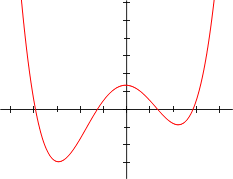


## LLOYD'S METHOD (RANDOM INITIALIZATION) CAN BE FAR FROM GLOBAL OPTIMUM

**A**
<img width="35%" src="figs/bad_init.png" />

<br/>
Which one of these configuration is better ? A or B ?
<br/>

**B**
<img width="35%" src="figs/good_init.png" />

# FURTHEST-FIRST HEURISTIC

Idea: semi-random initialization by **picking initial means as far from each other as possible**.

Choose ${\mu}_1$ arbitrarily between data points:

- For $k=[2,\ldots,K]$:
    - find the data point $x_m$ that is as far as possible from all previously selected means $[{\mu}_1,...,{\mu}_{k-1}]$
    - assign $ {\mu}_k\leftarrow x_m$
<br/><br/>
- This works well with Gaussian blobs, but it is **sensitive to outliers** !

# FURTHEST-FIRST HEURISTIC

Choose ${\mu}_1$ arbitrarily between data points

- For $k=[2,\ldots,K]$:
    - $m =\underbrace{\arg\max_m \underbrace{\big( \min_{k<k^{\prime}} \left| \left| {x}_m - {\mu}_k^{\prime}\right|\right|_2^2 \big)}_{\text{fix m, distance of closest centroids}}}_{\text{select points with max distances from previous}}$ 


You want the point that’s as far away from **all previous means as possible** !

# K-MEANS ++

K-means++ paper idea is pretty "young" (from 2007)

- Do NOT take `max()` across points when selecting the centroids.
- **Sample randomly but proportionally according to the distance between centroids**.
- $Pr[{\mu}_k={x}_m] \propto \min_{k<k^{\prime}} \left| \left| {x}_m - {\mu}_k^{\prime}\right|\right|_2^2$

[\[Arthur and Vassilvitskii 2007\]](https://theory.stanford.edu/~sergei/papers/kMeansPP-soda.pdf)

- Note that `randomness (K-means++) > randomness (Kmeans + furthest-first)` becuse with furthest-first we select at randonm only at the beginning; then all the rest is deterministic. 
- With `Kmeans++` at each cluster selection there is stochasticity involved.


[\[Arthur and Vassilvitskii 2007\]](https://theory.stanford.edu/~sergei/papers/kMeansPP-soda.pdf)

# HOW CAN WE SAMPLE FROM A SET OF DISTANCES ?  🤔

- Recall that before we did `max(d1,...,dm)`.
- $Pr[{\mu}_k={x}_m] \propto \min_{k<k^{\prime}} \left| \left| {x}_m - {\mu}_k^{\prime}\right|\right|_2^2 \qquad$

What does this mean?

### Higher distances should be more likely to get selected.

In [ ]:
dist =  np.array([1.18518298, 1.30917493, 1.10973212, 2.24523519, 1.01625606])
pmf = dist/dist.sum()

# INVERSE TRANSFORM SAMPLING

Inverse transform sampling is a probabilistic method used in machine learning to generate random samples from a given probability distribution. The method relies on the cumulative distribution function (CDF) of the distribution to generate the samples.

To use inverse transform sampling, we need to first compute the CDF of the probability distribution we want to sample from. The CDF gives the probability that a random variable takes a value less than or equal to a given value. We can use this information to generate random samples from the distribution.

The steps to use inverse transform sampling are as follows:

1. Choose a probability distribution that you want to sample from. This could be any probability distribution, such as a normal distribution, uniform distribution, or any other distribution.

2. Compute the cumulative distribution function (CDF) of the chosen probability distribution. The CDF gives the probability that a random variable takes a value less than or equal to a given value. It is defined as the integral of the probability density function (PDF) from negative infinity to the given value. The CDF is a monotonically increasing function that ranges from 0 to 1.

3. Generate a uniform random variable U between 0 and 1. This can be done using any method for generating random numbers in the range [0, 1], such as using a pseudorandom number generator.

4. Use the inverse of the CDF to compute the corresponding value of the random variable X that corresponds to the probability U. This step is the core of inverse transform sampling. To do this, we take the inverse of the CDF, which gives us a function that maps probabilities to corresponding values of X. We then apply this inverse function to U to get a value of X that corresponds to the probability U.

5. Repeat steps 3 and 4 as many times as necessary to generate the desired number of random samples. Each time step 4 is performed, we generate a new value of X that corresponds to a different probability U. By repeating this process many times, we can generate a large number of random samples from the desired probability distribution.

Inverse transform sampling is a powerful tool in machine learning, statistics, and other fields that rely on random number generation. It can be used to generate random samples from any probability distribution, making it an essential technique for many applications.

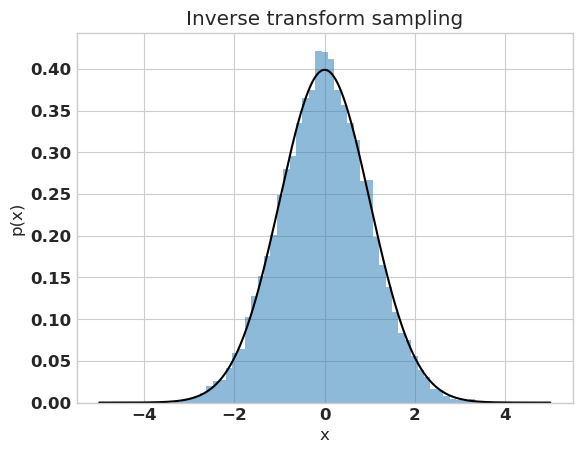

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Define the probability distribution we want to sample from
x = np.linspace(-5, 5, 1000)
pdf = np.exp(-x**2/2) / np.sqrt(2*np.pi)

# Compute the cumulative distribution function (CDF)
cdf = np.cumsum(pdf)
cdf /= cdf[-1]  # Normalize the CDF

# Generate random samples using inverse transform sampling
N = 10000
U = np.random.uniform(0, 1, N)
X = np.interp(U, cdf, x)

# Plot the results
fig, ax = plt.subplots()
ax.hist(X, bins=50, density=True, alpha=0.5)
ax.plot(x, pdf, 'k')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title('Inverse transform sampling')
plt.show()


In this example, we define a probability distribution by creating an array x of 1000 points between -5 and 5, and evaluating the normal distribution PDF at each point. We then compute the CDF by taking the cumulative sum of the PDF and normalizing it.

To generate random samples using inverse transform sampling, we first generate a uniform random variable U between 0 and 1 using numpy's random.uniform function. We then use the interp function to find the corresponding value of x for each value of U using the CDF.

Finally, we plot a histogram of the generated samples along with the original PDF. The resulting plot shows that the generated samples closely match the desired probability distribution.

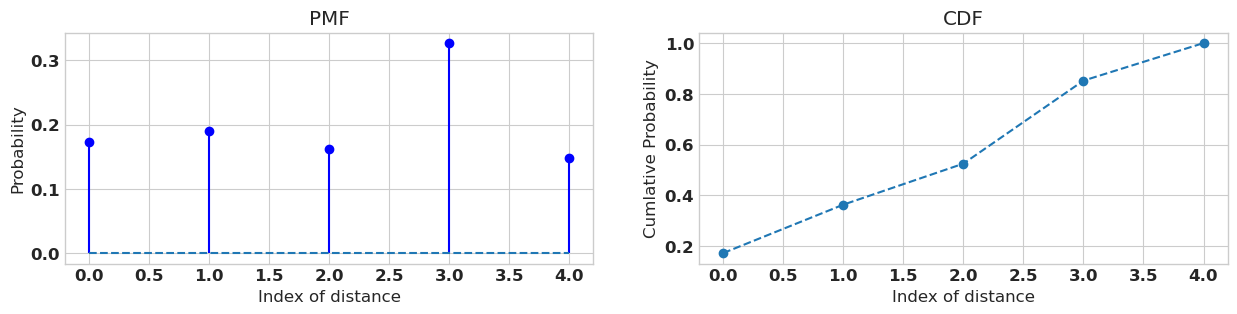

In [87]:
fig, axs = plt.subplots(1, 2)
fig.set_figheight(3)
fig.set_figwidth(15)
# PDF
axs[0].stem(pmf, linefmt='b-', markerfmt='bo', basefmt='--')
axs[0].set_title('PMF')
axs[0].set_xlabel('Index of distance')
axs[0].set_ylabel('Probability')
axs[0].set_aspect('auto')
# CDF
axs[1].plot(pmf.cumsum(), 'o--')
axs[1].set_title('CDF')
axs[1].set_xlabel('Index of distance')
axs[1].set_ylabel('Cumlative Probability')
axs[1].set_aspect('auto')
plt.show()

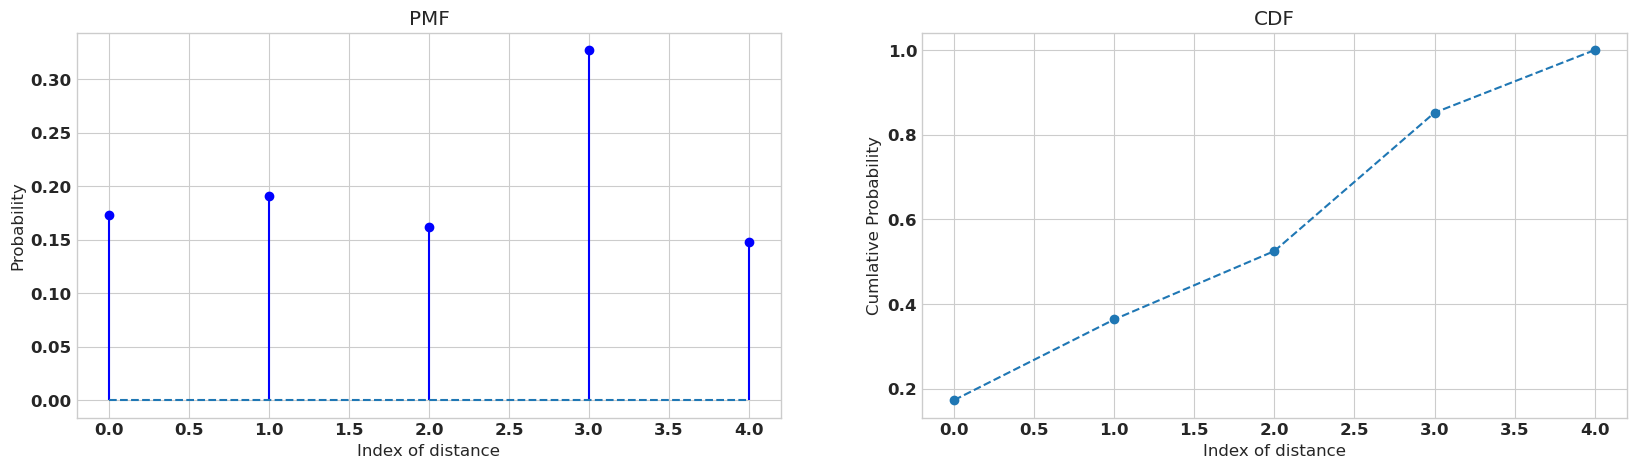

In [89]:
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(20)
# PDF
axs[0].stem(pmf, linefmt='b-', markerfmt='bo', basefmt='--')
axs[0].set_title('PMF')
axs[0].set_xlabel('Index of distance')
axs[0].set_ylabel('Probability')
axs[0].set_aspect('auto')
# CUMSUM
axs[1].plot(pmf.cumsum(), 'o--')
axs[1].set_title('CDF')
axs[1].set_xlabel('Index of distance')
axs[1].set_ylabel('Cumlative Probability')
axs[1].set_aspect('auto')
#axs[1].stem(pmf, linefmt='b-', markerfmt='bo', basefmt='--')
plt.show()

Nice read https://stats.stackexchange.com/questions/129554/inverse-sampling-for-discrete-data

# K-MEANS++ FULL RECIPE

1. Choose ${\mu}_1$ arbitrarily between data points.
2. For $k=[2,\ldots,K]$:
    - **Inverse Transform Sampling** wrt to distances between centroids
    - $Pr[{\mu}_k={x}_m] \propto \min_{k<k^{\prime}} \left| \left| {x}_m - {\mu}_k^{\prime}\right|\right|_2^2 \qquad$
3. Repeat until convergence Lloyd’s method:
    - **Assignment step:** $\forall i\in[1,N] \quad y_i =  \arg\min_k || {x}_i -{\mu}_k ||_2^2 $
    - **Update step:** $\forall k\in[1,K] \quad  {\mu}_k \leftarrow \frac{\sum_i \delta\{y_i=k\}{x}_i}{\sum_i \delta\{y_i=k\}}$

# K-MEANS: A FAMILY OF ALGORITHMS PARAMETRIZED BY THE NORM USED

- K-means++ opens the possibilty of interpret K-means as a _familiy_ of algorithms.
- K-means++ is also called K-means with $D^2$ sampling because we sample proportionally to Euclidean norm $\ell_2$.
- Interpolate between random and furthest point initialization.

You can think of sampling w.r.t. to:
   - $\ell_0$ "norm" (total number of non-zero element in a vector) $\rightarrow$ random sampling.
   - $\ell_2$ norm $\rightarrow$ when we have K-means++.
   - $\ell_{\infty}$ norm $\rightarrow$ then we have K-means with furthest-first heuristic (we take max of distances).



# HOW DO WE CHOOSE K ?

- Find a `k` that gives large gap between k-1 means and k-means cost function.
- Hold-out validation/cross-validation on auxiliary task (e.g., supervised learning task).
  - We will explain this very soon

# How do we choose K?
- Simply using $\mathcal{L}$ as a notion of goodness is insufficient (analogous to overfitting in a supervised setting). 
- A number of “information criteria” have been proposed to try to address this problem. They all effectively boil down to “regularizing” K so that the model cannot grow to be too complicated.
- The two most popular are the Bayes Information Criteria (BIC) and the Akaike Information Criteria (AIC), defined below in the context of K-means:

$$ \text{(BIC)} \qquad \arg\min_K \mathcal{L}_K  + \underbrace{K\cdot\log(D)}_{\text{regularization}}$$
$$ \text{(AIC)}  \qquad \arg\min_K \mathcal{L}_K  + \underbrace{K\cdot 2D}_{\text{regularization}}$$

- Intuition is that `it is OK for the loss to go down but do not make the model (number of K) too complex`.

# K-means Complexity

- **Initialization:** $\mathcal{O}(nd)$ One pass over data to select k centers, So $\mathcal{O}(ndk)$ time in total.
- **Lloyd’s method:** $\mathcal{O}(ndk)$

- **Exponential # of rounds** in the worst case [AV07].
- Expected **polynomial time in the smoothed analysis** (non worst-case) model!
- Does well in practice

## Putting all together

In [ ]:
from sklearn.datasets import make_blobs
N_centers = 25
X, y = make_blobs(n_samples=1500,
                    n_features=2,
                    centers=N_centers,
                    cluster_std=.42,
                    shuffle=True,
                    random_state=0)

plt.scatter(X[:, 0], X[:, 1], c='black', marker='o', s=50)
plt.show() 

In [ ]:
def inverse_sampling(pmf, n_samples):
    U = np.random.rand(n_samples)
    sampled_idx = np.argmin((U[:, None] > pmf.cumsum()), axis=1)
    return sampled_idx


def distance(X, centers):
    P = X[:, np.newaxis, :]  # Nx1xD
    diff_sq = (P - centers)**2  # Nx1xD - KxD -> NxKxD # broadcasting
    # more info on broadcasting https://numpy.org/doc/stable/user/basics.broadcasting.html
    # dist = sum_over_axis(diff^2) then take argmin of dist across centers
    diff_sq_sum = diff_sq.sum(axis=2)
    return diff_sq_sum


def init(X, K, plusplus=True):
    N, dim = X.shape
    if not plusplus:
        print('> Init with random sampling')
        # we select k samples from the points we have randomly
        idx = np.random.choice(N, K)
        # the centers are just the k-random sampled points
        return X[idx]
    else:
        print('> Init with kmeans++')
        # we select a point
        idx_first = np.random.choice(N, 1)
        # init the centers and distances
        centers = X[idx_first]
        dists = distance(X, centers)
        for k in range(1, K):  # for [1.....K-1]
            # compute min across all k-centers, for all points
            # dists is NxK so min_dist is Nx1
            min_dist = dists.min(axis=1)
            # select one of the N proportional to higher distance
            idx = inverse_sampling(min_dist/min_dist.sum(), 1)
            new_center = X[idx]
            # compute distance between all points to new center
            dist_new = distance(X, new_center)
            # update pool of centers and distances
            centers = np.vstack([centers, new_center])
            dists = np.hstack([dists, dist_new])
        # the centers are computed after the loop
        return centers


def get_assignments(X, centers):
    dist_sq = distance(X, centers)  # get distance #Nxk
    y = dist_sq.argmin(axis=1)  # select argmin distance #Nx1
    return y, dist_sq.min(axis=1)  # Nx1 and the values inside go from [1...K]


def update_centers(X, y, K):
    # select the points to the k center and remove N dimension with mean over axis 0
    # TODO: remove the for
    return np.array([X[y == k].mean(axis=0) for k in range(K)])

In [ ]:
# Double check
np.random.seed(0)  # make the method deterministic
from sklearn.metrics import pairwise_distances_argmin
centers = init(X, N_centers)
y_assignments, _ = get_assignments(X, centers)
labels = pairwise_distances_argmin(X, centers)
assert np.array_equal(labels, y_assignments), 'Assignment not correct!'

In [ ]:
def kmeans(X, n_clusters):
    np.random.seed(0)  # make the method deterministic
    iter = 1
    # 1. init random sample the centers
    centers = init(X, n_clusters)
    loss = []
    while True:
        # 2. Assignment step
        y_assignments, dist_sq = get_assignments(X, centers)
        # distance between points and center, average over points
        loss.append(dist_sq.mean())
        # 3. Update step
        new_centers = update_centers(X, y_assignments, n_clusters)

        # 4. Check for convergence
        # If two last losses are close enough we stop
        if len(loss) > 2 and np.allclose(loss[-2], loss[-1], atol=1e-5):
            break
        # update cluster for next iter
        centers = new_centers

        print(f'> Iteration {iter}: loss {loss[-1]}')
        iter += 1

    return centers, y_assignments, loss

In [ ]:
centers, y_est, loss = kmeans(X, N_centers)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].scatter(*X.T, c=y_est,
              s=50, cmap='viridis')
ax[0].set_title('Result')
_ = ax[0].scatter(*centers.T,
                  s=250,
                  marker='*',
                  c='red',
                  label='centroids')
_ = ax[1].plot(loss)
_ = ax[1].set_title('Loss function')
_ = ax[2].scatter(*X.T, c=y,
              s=50, cmap='viridis')
_ = ax[2].set_title('Expected')

# Applications

The applications are inspired from [this website](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)

## Clustering of Digits (2D images) for "classification"

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

# Let's see the data

- Each datapoint is a 8x8 image of a digit.

| Attribute  | Value |
| ------------- |:-------------:|
| Classes       | 10     |
| Samples per class      | ~180     |
| Samples total       | 1797   |
| Dimensionality      | 64   |
| Features      | int 0-16   |

# Let's see the histogram of features (pixel colors)

In [ ]:
_ = plt.hist(digits.data.flatten())

In [ ]:
np.random.seed(13)  # fixing the seed to see same pictures

fig, ax = plt.subplots(2, 5, figsize=(8, 3))
idx = np.random.choice(digits.data.shape[0], 10)
labels = digits.target[idx, ...]
points = digits.data[idx, ...].reshape(-1, 8, 8)
for axi, vector, y in zip(ax.flat, points, labels):
    axi.set(xticks=[], yticks=[])
    axi.imshow(vector, interpolation='none', cmap='gray')
    axi.set_title(y)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(digits.data,digits.target, test_size=0.1,
                                                    random_state=0, stratify=digits.target)

In [ ]:
plt.bar(*np.unique(y_train, return_counts=True));

In [ ]:
plt.bar(*np.unique(y_test, return_counts=True));

## Compute the mode from a distribution

Informally, the mode is the most frequent element

- We can count the frequency of each value
- Take the most frequent value

```python
u, counts = np.unique([1,2,3,4,1,1,1,], return_counts=True)
mode = u[counts.argmax()] # will print 1 since 1 is most frequent
                          # 4 time present
```

# Let's run our K-means on the digits

In [ ]:
N_centers = 10 # we assume to know that there are 10 digits
centers, y_est, loss = kmeans(X_train, N_centers)

# Now let's visualize the centers

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers_img = centers.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers_img):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='none', cmap='gray')

###  It looks like a smoothed version of before...

- We see that even without the labels, `KMeans` is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.
- Probably in this case, the dataset is "easy" and distances among points have a lot of informations.

- Because k-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted. 
   - We can fix this by matching each learned cluster label with the true labels found in them
   - In this step we are only computing the mapping between each "color" that kmeans assign to the cluster to each digit label
   - We **CANNOT** change the assignment to each cluster. This is meant just to map "colors" to actual digit labels. 

In [ ]:
def get_mode(X):
    values, counts = np.unique(X, return_counts=True)
    return values[counts.argmax()]

# Nx1
labels = np.zeros_like(y_est)
# 10x1
center_label = np.zeros((N_centers), dtype=np.int32)

for i in range(N_centers):
    mask = (y_est == i)
    mode_y = get_mode(y_train[mask])
    labels[mask] = mode_y
    center_label[i] = mode_y

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, labels)

## Not bad at accuracy of ~70% just with unsupervised method on the "training set" though no label has been used for training
## Remember: Random chance accuracy over 10 classes is 1/10 ~10%.
## We also have validated our implementation of K-means

## Further, There is hope this may translate to test set

In [ ]:
# sum over axis of dimensionality of squared difference
# Nx1x64 vs 10x64 --> Nx10x64 --sum axis 2 ---> Nx10
# we match the test wrt to the center (there might be other classification methods)
L2_square = ((X_test[...,np.newaxis,:] - centers)**2).sum(axis=2)

In [ ]:
# Nx10 -- argmin over axis --> Nx1
idx_cluster = L2_square.argmin(axis=1)

In [ ]:
y_test_estimated = center_label[idx_cluster]

In [ ]:
accuracy_score(y_test, y_test_estimated)

## Not bad at accuracy of ~67% just with unsupervised method on the "test split"
## Remember: Random chance accuracy over 10 classes is 1/10 ~10%


## Note now things are easy because:
1. `digits` is an easy dataset. Which means distance in the pixel-space contains  useful informations.
2. In real-world unsupervised learning does not work so well.

It is OK to implement things manually in a course but remember that you can use  optimized implementation via sklearn.

```python
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
```

## Homework 1a:  Repeat the experiments but not project the data onto a lower dimensional subspace and retain 99% of the variance. Does the classification improve? <ins>[WITHOUT sklearn, rewriting all code without looking at this; for each line of code write the matrix shape to validate your implementation]</ins>

### _Note: I did not try so I do not know what happens, but you can make hypothesis._ Before running it, make an hypothesis of what is going to happen following a rationale in your mind, based on what we studied so far. Then after formulating the hypothesis, do the experiments.

### Tips 1: Try to retain all the features (i.e. 100% of variance) in case accuracy does not improve. In this case you are just rotating the data and decorrelating the covariance matrix

### Tips 2: If you try multiple runs, remember to FIX THE RANDOM SEED to make the experiments comparable

 

## Homework 1b: To debug what happens, you can plot the data in 2D or 3D with PCA and show the digits ID with a color using a colormap

## Homework 1c _[Advanced]_: To visualize the digits dataset, now use an advanced dimensionality reduction algorithm called [`t-SNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE). Unlike PCA this method supports, multiple non-linear structures so you should see the digits more separated in 2D.  For this use sklearn!

## Homework 2: Repeat everyting but now use sklearn.

# Color Compression with K-means

In [ ]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
ax.set(xticks=[], yticks=[])
ax.imshow(china)

In [ ]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
ax.set(xticks=[], yticks=[])
ax.imshow(china)

- This is a {{china.shape}} image `WxHx3` where 3 is RGB but can also be seen as a 3D point cloud.
- Each pixel is a point in 3D where 3 dimensions are R, G, B

#### let's normalized the data to stay in 3D hypercube of length 1

```python
data = china/255.0 # scale all poitns to 0...1
data = data.reshape(-1,3)
```

In [ ]:
data = china/255.0 # scale all poitns to 0...1
data = data.reshape(-1,3)
data.shape

# The 3D point cloud

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
data_sampled = data[::10] #1 point every 10 to go faster
ax.scatter(*data_sampled.T, marker='.', color=data_sampled)
ax.set_xlabel('R')
ax.set_ylabel('G')
_ = ax.set_zlabel('B')
ax.view_init(elev=10, azim=(0))

# How many possible points in this 3D cube?

### $256^3 \approx 16$ millions

# Now we quantize the colors with K-means to 16 colors

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(16)
kmeans.fit(data)
y_est = kmeans.predict(data) # predict cluster center (project)
new_colors = kmeans.cluster_centers_[y_est] # backproject to the colors centers  

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
data_sampled = new_colors[::10]  # 1 point every 10 to go faster
ax.scatter(*data_sampled.T, marker='.', color=data_sampled, s=200)
ax.set_xlabel('R')
ax.set_ylabel('G')
_ = ax.set_zlabel('B')
ax.view_init(elev=10, azim=(0))

### Note

- **Important:** new_colors has the same shape of original images but inside the colors get "quantized" into 16 possible colors (the k-means centers)

In [ ]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image (8 bit per pixel)', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image (4 bit per pixel + centers)', size=16);

# Bag of Visual Words: how to construct an image recogntion pipeline

<img width="70%" src="figs/visual_words.png" />

[Figure Credit Prof. Vedaldi - Oxford](https://www.robots.ox.ac.uk/~vedaldi/assets/teach/2021/c18-lectures-handout.pdf)

<img width="70%" src="figs/visual_words_hist.png" />

[Figure Credit Prof. Vedaldi - Oxford](https://www.robots.ox.ac.uk/~vedaldi/assets/teach/2021/c18-lectures-handout.pdf)